In [1]:
import pandas as pd
import numpy as np
import json
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

# **Constants**

In [2]:
columns_norm_forms = {
    'УНОМ': 'UNOM',
    'Учётный номер объекта адресации в БД БТИ (кроме помещения и комнаты)': 'UNOM'
}

In [3]:
with open('../columns_info.json') as f:
    d = json.load(f)
    usless_col = d['useless_columns']
    useless_by_classification = d['useless_by_classification']
    categorical_columns = d['categorical_columns']



# **Functions**

In [31]:

def make_categorical(df: pd.DataFrame, cc):
    ds = dict()
    for i in cc:
        ds[i] = factorizer(df[i])
        df[i] = df[i].map(lambda a: ds[i][a])
    return df, ds

def column_preprocessor(columns: pd.Index):
    return pd.Index([columns_norm_forms[i] if i in columns_norm_forms else i for i in columns])


def replace_bad_spaces(df: pd.Index) -> pd.DataFrame:
    c = df.map(lambda a: str(a).rstrip().lstrip())
    return c


def remove_useless_columns(df: pd.DataFrame):
    df = df.loc[:, ~df.columns.isin(usless_col)]
    return df


def factorizer(c: pd.Series):
    x = c.unique()
    d = {j: i for i, j in enumerate(x)}
    return d


def process_single_date(df: pd.DataFrame):
    d = df.copy()
    for i in d.columns:
        if 'дата' in i.lower():
            d[i] = (pd.to_datetime(d[i], dayfirst=True) - pd.Timestamp(year=1990, month=1, day=1)).map(lambda a: a.days).astype(int)
    return d


In [5]:
def queue_clean_roof_processor(df: pd.DataFrame):
    df['Очередность уборки кровли'] = df['Очередность уборки кровли'].map(lambda a: int(a.split(' ')[0]) if type(a) is str else int(a) if not pd.isna(a) else a)
    return df

In [6]:
def data_frame_loader(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = column_preprocessor(df.columns)
    df.columns = replace_bad_spaces(df.columns)
    df = remove_useless_columns(df)
    df = queue_clean_roof_processor(df)
    return df

# **Load table**

In [42]:
table = data_frame_loader('../main_datasets/builded_datasets/buildings_description.csv')

/tmp/ipykernel_400276/2354812253.py:2: DtypeWarning: Columns (39,42,43,44,59,64,67,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [43]:
(table["Количество этажей"] == table['Этажность']).sum()

852767

In [44]:
table

,Район,Потребители,Группа,UNOM,Центральное отопление(контур),Марка счетчика,Адрес по БТИ,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,Общая площадь жилых помещений,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ,Типы жилищного фонда,Статусы МКД,Полный адрес,№ ОДС,Адрес ОДС,Потребитель (или УК),Номер ТП,Административный округ,Муниципальный округ,Населенный пункт,Улица,Тип номера дом,Номер дома,Номер корпуса,Тип номера строения/сооружения,Номер строения,Материал,Назначение,Класс,Тип,Этажность,Признак,Тип объекта адресации,На территории Москвы,Полное юридическое написание адреса или описание местоположения,Субъект РФ,Поселение,Населённый пункт,Наименование элемента планировочной структуры или улично-дорожной сети,Дополнительный адресообразующий элемент,Уточнение дополнительного адресообразующего элемента,"Тип номера дома, владения, участка","Номер дома, владения, участка",Тип номера корпуса,Страна,"Тип номера строения, сооружения",Внутригородская территория,"Номер строения, сооружения",Тип номера помещения,Номер помещения,Тип номера комнаты,Номер комнаты,"Муниципальный округ, поселение",Дата регистрации адреса в Адресном реестре,Уникальный номер адреса в государственном адресном реестре,Дата регистрации адреса в государственном адресном реестре,Кадастровый номер объекта недвижимости (кроме земельного участка),Документ-основание регистрационных действий,Дата документа о регистрации адреса,Тип адреса,Вид адреса,Состояние адреса,Статус адреса,geoData,geodata_center
0,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,ЦО1,АТ-Т-2,"город Москва, Новокосинская улица, дом 12, кор...",П-3/16,17,2.0,136.0,8694.7,8677.4,NaN,панельные,нет,2.0,2.0,NaN,мягкая-совмещенная с рубероидным покрытием,МКД,в эксплуатации,"город Москва, Новокосинская улица, дом 12, кор...",NaN,NaN,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",04-09-302,Восточный административный округ,муниципальный округ Новокосино,NaN,Новокосинская улица,дом,12,5.0,NaN,NaN,панельные,многоквартирный дом,жилые,Здание,17.0,NaN,Здание,да,"Российская Федерация, город Москва, внутригоро...",город Москва,NaN,NaN,Новокосинская улица,NaN,NaN,дом,12,корпус,Российская Федерация,NaN,внутригородская территория муниципальный округ...,NaN,NaN,NaN,NaN,NaN,муниципальный округ Новокосино,25.02.2000,B2E08CE7-3F13-4301-8A4C-66291AC31F12,27.02.2012,KAD_N:77:03:0009004:1118\n\n,Решение исполкома райсовета,14.03.1990,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.857500194, 55.736633236], [...","{coordinates=[37.857673062, 55.736430968], typ..."
1,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,ЦО1,АТ-Т-2,"город Москва, Новокосинская улица, дом 12, кор...",П-3/16,17,2.0,136.0,8694.7,8677.4,NaN,панельные,нет,2.0,2.0,NaN,мягкая-совмещенная с рубероидным покрытием,МКД,в эксплуатации,"город Москва, Новокосинская улица, дом 12, кор...",NaN,NaN,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",04-09-302,Восточный административный округ,муниципальный округ Новокосино,NaN,Новокосинская улица,дом,12,5.0,NaN,NaN,панельные,многоквартирный дом,жилые,Здание,17.0,NaN,Здание,да,"Российская Федерация, город Москва, внутригоро...",город Москва,NaN,NaN,Новокосинская улица,NaN,NaN,дом,12,корпус,Российская Федерация,NaN,внутригородская территория муниципальный округ...,NaN,NaN,NaN,NaN,NaN,муниципальный округ Новокосино,25.02.2000,B2E08CE7-3F13-4301-8A4C-66291AC31F12,27.02.2012,KAD_N:77:03:0009004:1118\n\n,Решение исполкома райсовета,14.03.1990,Официальный,Адрес,Зарегистрирован в АР,Внесён в ГКН,"{coordinates=[[[37.857500194, 55.736633236], [...","{coordinates=[37.857673062, 55.736430968], typ..."
2,Новокосино,"ГБУ ""ЖИЛИЩНИК РАЙОНА НОВОКОСИНО""",МКД,82024,ЦО1,АТ-Т-2,"город Москва, Новокосинская улица, дом 12, кор...",П-3/16,17,2.0,136.0,8694.7,8677.4,NaN,панельные,нет,2.0,2.0,NaN,мягкая-совмещенная с рубероидным покрытием,МКД,в экспл

# **First look up**

In [45]:
uniq_el_in_col_counts = {i: len(table[i].dropna().unique()) for i in table.columns}
useless_columns_by_count = [i for i in uniq_el_in_col_counts if uniq_el_in_col_counts[i]<=1]

In [46]:
with open('../useless_columns_by_count.json', 'w') as f:
    json.dump(useless_columns_by_count, f)


In [47]:
table = table.drop(useless_columns_by_count, axis = 1)

In [48]:
table = table.iloc[:, ~table.columns.isin(useless_by_classification)]

In [49]:
print(*[f'{i}: {table[i].isna().astype(int).sum()} / {(~table[i].isna()).astype(int).sum()}' for i in table.columns], sep='\n')

Район: 0 / 852980
Потребители: 0 / 852980
Группа: 0 / 852980
Центральное отопление(контур): 0 / 852980
Марка счетчика: 0 / 852980
Серии проектов: 0 / 852980
Количество этажей: 0 / 852980
Количество подъездов: 639 / 852341
Количество квартир: 852 / 852128
Общая площадь: 0 / 852980
Общая площадь жилых помещений: 0 / 852980
Износ объекта (по БТИ): 668595 / 184385
Материалы стен: 0 / 852980
Признак аварийности здания: 0 / 852980
Количество пассажирских лифтов: 0 / 852980
Количество грузопассажирских лифтов: 0 / 852980
Очередность уборки кровли: 446490 / 406490
Материалы кровли по БТИ: 852 / 852128
№ ОДС: 12964 / 840016
Потребитель (или УК): 0 / 852980
Номер ТП: 3183 / 849797
Материал: 1694 / 851286
Назначение: 0 / 852980
Этажность: 0 / 852980
Дата регистрации адреса в Адресном реестре: 0 / 852980
Дата регистрации адреса в государственном адресном реестре: 0 / 852980
Документ-основание регистрационных действий: 0 / 852980
Дата документа о регистрации адреса: 0 / 852980
Статус адреса: 0 / 8

In [50]:
table, d = make_categorical(table, categorical_columns)

In [35]:
for i in d:
    with open(f'../factorized_objects/{i}.json', 'w') as f:
        json.dump(d[i], f)

In [51]:
table

,Район,Потребители,Группа,Центральное отопление(контур),Марка счетчика,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,Общая площадь жилых помещений,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ,№ ОДС,Потребитель (или УК),Номер ТП,Материал,Назначение,Этажность,Дата регистрации адреса в Адресном реестре,Дата регистрации адреса в государственном адресном реестре,Документ-основание регистрационных действий,Дата документа о регистрации адреса,Статус адреса
0,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,NaN,0,0,2.0,2.0,NaN,0,0,0,0,0,0,17.0,25.02.2000,27.02.2012,0,14.03.1990,0
1,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,NaN,0,0,2.0,2.0,NaN,0,0,0,0,0,0,17.0,25.02.2000,27.02.2012,0,14.03.1990,0
2,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,NaN,0,0,2.0,2.0,NaN,0,0,0,0,0,0,17.0,25.02.2000,27.02.2012,0,14.03.1990,0
3,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,NaN,0,0,2.0,2.0,NaN,0,0,0,0,0,0,17.0,25.02.2000,27.02.2012,0,14.03.1990,0
4,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,NaN,0,0,2.0,2.0,NaN,0,0,0,0,0,0,17.0,25.02.2000,27.02.2012,0,14.03.1990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852975,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,NaN,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,16.12.2003,27.02.2012,1,11.12.2003,0
852976,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,NaN,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,16.12.2003,27.02.2012,1,11.12.2003,0
852977,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,NaN,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,16.12.2003,27.02.2012,1,11.12.2003,0
852978,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,NaN,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,16.12.2003,27.02.2012,1,11.12.2003,0


In [52]:
table = process_single_date(table)

In [53]:
table = table.fillna(-1)

In [54]:
table

,Район,Потребители,Группа,Центральное отопление(контур),Марка счетчика,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,Общая площадь жилых помещений,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ,№ ОДС,Потребитель (или УК),Номер ТП,Материал,Назначение,Этажность,Дата регистрации адреса в Адресном реестре,Дата регистрации адреса в государственном адресном реестре,Документ-основание регистрационных действий,Дата документа о регистрации адреса,Статус адреса
0,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,-1.0,0,0,2.0,2.0,-1.0,0,0,0,0,0,0,17.0,3707,8092,0,72,0
1,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,-1.0,0,0,2.0,2.0,-1.0,0,0,0,0,0,0,17.0,3707,8092,0,72,0
2,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,-1.0,0,0,2.0,2.0,-1.0,0,0,0,0,0,0,17.0,3707,8092,0,72,0
3,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,-1.0,0,0,2.0,2.0,-1.0,0,0,0,0,0,0,17.0,3707,8092,0,72,0
4,0,0,0,0,0,0,17,2.0,136.0,8694.7,8677.4,-1.0,0,0,2.0,2.0,-1.0,0,0,0,0,0,0,17.0,3707,8092,0,72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852975,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,-1.0,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,5097,8092,1,5092,0
852976,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,-1.0,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,5097,8092,1,5092,0
852977,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,-1.0,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,5097,8092,1,5092,0
852978,3,5,0,0,1,1,5,7.0,117.0,10470.2,7453.7,-1.0,2,0,0.0,0.0,1.0,1,97,4,681,2,0,5.0,5097,8092,1,5092,0


In [55]:
table.to_csv('../main_datasets/normalized_data/buildings_info_normalize.csv', index=False)

# **Analize**

In [56]:
table = pd.read_csv('../main_datasets/normalized_data/buildings_info_normalize.csv')

In [57]:
scaler = StandardScaler().fit(table)
with open('../models/scalers/buildings_info_normalize.pkl', 'wb') as f:
    pickle.dump(scaler, f)
table_scaled = pd.DataFrame(scaler.transform(table), columns=table.columns)

In [58]:
table_scaled.drop_duplicates()

,Район,Потребители,Группа,Центральное отопление(контур),Марка счетчика,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,Общая площадь жилых помещений,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ,№ ОДС,Потребитель (или УК),Номер ТП,Материал,Назначение,Этажность,Дата регистрации адреса в Адресном реестре,Дата регистрации адреса в государственном адресном реестре,Документ-основание регистрационных действий,Дата документа о регистрации адреса,Статус адреса
0,-1.452150,-0.874695,-0.130754,-0.106949,-0.627917,-0.838164,1.973014,-0.650919,0.281616,0.562416,0.693424,-0.424405,-0.908209,-0.015804,-0.025569,1.261292,-0.922764,-0.547340,-1.686111,-0.884294,-1.561442,-0.884858,-0.056036,1.973151,-3.615246,-0.119918,-6.547605,-4.120661,-0.015804
206,-1.452150,-0.874695,-0.130754,2.709698,-0.627917,-0.771355,3.156669,-0.650919,0.665258,0.924877,0.966613,-0.334235,-0.449635,-0.015804,-0.025569,2.858548,-0.922764,-0.547340,-1.686111,-0.884294,-1.557063,-0.480733,-0.056036,3.156853,0.562216,-0.119918,0.136122,0.303724,-0.015804
416,-1.452150,-0.874695,-0.130754,-0.106949,-0.627917,-0.771355,3.156669,-0.650919,0.665258,0.924877,0.966613,-0.334235,-0.449635,-0.015804,-0.025569,2.858548,-0.922764,-0.547340,-1.686111,-0.884294,-1.557063,-0.480733,-0.056036,3.156853,0.562216,-0.119918,0.136122,0.303724,-0.015804
628,-1.452150,-0.839125,-0.130754,-0.106949,-0.344802,-0.704546,1.262821,-0.650919,-0.030093,-0.225280,-0.153041,-0.424405,-0.908209,-0.015804,0.673041,-0.335964,-0.922764,-0.547340,-1.686111,-0.847728,-1.552683,-0.884858,-0.056036,1.262930,0.686734,-0.119918,0.136122,0.345972,-0.015804
841,-1.235862,-0.803554,-0.130754,-0.106949,-0.344802,-0.637736,-0.631027,-0.198703,-0.689476,-0.232715,-0.328564,-0.424405,0.008938,-0.015804,0.323736,-0.335964,0.574162,0.530762,-1.686111,-0.811162,-1.548304,-0.076608,-0.056036,-0.630993,1.065172,-0.119918,0.136122,0.471886,-0.015804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851928,1.143313,0.085713,-0.130754,-0.106949,-0.344802,1.232927,0.079166,0.705729,0.785146,0.486520,0.493704,-0.424405,0.008938,-0.015804,1.022346,-0.335964,-0.922764,-0.547340,-1.686111,0.249248,0.470597,-0.076608,-0.056036,0.079228,0.344920,-0.119918,0.136122,0.228342,-0.015804
852141,-1.452150,5.350175,-0.130754,-0.106949,-0.344802,0.097167,1.262821,-0.198703,0.641280,0.352569,0.464015,-0.424405,-0.908209,-0.015804,1.371651,-0.335964,-0.922764,-0.547340,-1.686111,5.624430,-1.552683,-0.884858,-0.056036,1.262930,-3.607921,-0.119918,-6.547605,-4.120661,-0.015804
852354,-1.452150,-0.874695,-0.130754,-0.106949,-0.344802,0.097167,1.262821,-0.198703,0.641280,0.325627,0.435653,-0.424405,-0.908209,-0.015804,1.371651,-0.335964,-0.922764,-0.547340,-1.686111,-0.884294,0.124625,-0.884858,-0.056036,1.262930,-3.615246,-0.119918,-6.547605,-4.120661,-0.015804
852567,-0.803284,0.476991,-0.130754,-0.106949,-0.627917,-0.771355,1.262821,-1.103136,-0.725443,-0.395188,-0.458597,-0.334235,-0.449635,-0.015804,-0.374875,0.462664,-0.922764,-0.547340,-1.686111,0.724604,2.384393,-0.480733,-0.056036,1.262930,2.600896,-0.119918,0.136122,0.994595,-0.015804


# **Select most usefull columns**

In [59]:
from sklearn.feature_selection import VarianceThreshold, chi2

In [60]:
x = VarianceThreshold(threshold=1).fit(table_scaled)
x.get_feature_names_out()

array(['Группа', 'Центральное отопление(контур)', 'Серии проектов',
       'Количество квартир', 'Износ объекта (по БТИ)', 'Материалы стен',
       'Признак аварийности здания',
       'Количество грузопассажирских лифтов', 'Потребитель (или УК)',
       'Номер ТП', 'Материал', 'Назначение',
       'Документ-основание регистрационных действий',
       'Дата документа о регистрации адреса', 'Статус адреса'],
      dtype=object)

# **Make clusterization**

In [61]:
ddt = table_scaled.drop_duplicates().reset_index().drop('index', axis=1)

In [69]:
ddt

,Район,Потребители,Группа,Центральное отопление(контур),Марка счетчика,Серии проектов,Количество этажей,Количество подъездов,Количество квартир,Общая площадь,Общая площадь жилых помещений,Износ объекта (по БТИ),Материалы стен,Признак аварийности здания,Количество пассажирских лифтов,Количество грузопассажирских лифтов,Очередность уборки кровли,Материалы кровли по БТИ,№ ОДС,Потребитель (или УК),Номер ТП,Материал,Назначение,Этажность,Дата регистрации адреса в Адресном реестре,Дата регистрации адреса в государственном адресном реестре,Документ-основание регистрационных действий,Дата документа о регистрации адреса,Статус адреса
0,-1.452150,-0.874695,-0.130754,-0.106949,-0.627917,-0.838164,1.973014,-0.650919,0.281616,0.562416,0.693424,-0.424405,-0.908209,-0.015804,-0.025569,1.261292,-0.922764,-0.547340,-1.686111,-0.884294,-1.561442,-0.884858,-0.056036,1.973151,-3.615246,-0.119918,-6.547605,-4.120661,-0.015804
1,-1.452150,-0.874695,-0.130754,2.709698,-0.627917,-0.771355,3.156669,-0.650919,0.665258,0.924877,0.966613,-0.334235,-0.449635,-0.015804,-0.025569,2.858548,-0.922764,-0.547340,-1.686111,-0.884294,-1.557063,-0.480733,-0.056036,3.156853,0.562216,-0.119918,0.136122,0.303724,-0.015804
2,-1.452150,-0.874695,-0.130754,-0.106949,-0.627917,-0.771355,3.156669,-0.650919,0.665258,0.924877,0.966613,-0.334235,-0.449635,-0.015804,-0.025569,2.858548,-0.922764,-0.547340,-1.686111,-0.884294,-1.557063,-0.480733,-0.056036,3.156853,0.562216,-0.119918,0.136122,0.303724,-0.015804
3,-1.452150,-0.839125,-0.130754,-0.106949,-0.344802,-0.704546,1.262821,-0.650919,-0.030093,-0.225280,-0.153041,-0.424405,-0.908209,-0.015804,0.673041,-0.335964,-0.922764,-0.547340,-1.686111,-0.847728,-1.552683,-0.884858,-0.056036,1.262930,0.686734,-0.119918,0.136122,0.345972,-0.015804
4,-1.235862,-0.803554,-0.130754,-0.106949,-0.344802,-0.637736,-0.631027,-0.198703,-0.689476,-0.232715,-0.328564,-0.424405,0.008938,-0.015804,0.323736,-0.335964,0.574162,0.530762,-1.686111,-0.811162,-1.548304,-0.076608,-0.056036,-0.630993,1.065172,-0.119918,0.136122,0.471886,-0.015804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4172,1.143313,0.085713,-0.130754,-0.106949,-0.344802,1.232927,0.079166,0.705729,0.785146,0.486520,0.493704,-0.424405,0.008938,-0.015804,1.022346,-0.335964,-0.922764,-0.547340,-1.686111,0.249248,0.470597,-0.076608,-0.056036,0.079228,0.344920,-0.119918,0.136122,0.228342,-0.015804
4173,-1.452150,5.350175,-0.130754,-0.106949,-0.344802,0.097167,1.262821,-0.198703,0.641280,0.352569,0.464015,-0.424405,-0.908209,-0.015804,1.371651,-0.335964,-0.922764,-0.547340,-1.686111,5.624430,-1.552683,-0.884858,-0.056036,1.262930,-3.607921,-0.119918,-6.547605,-4.120661,-0.015804
4174,-1.452150,-0.874695,-0.130754,-0.106949,-0.344802,0.097167,1.262821,-0.198703,0.641280,0.325627,0.435653,-0.424405,-0.908209,-0.015804,1.371651,-0.335964,-0.922764,-0.547340,-1.686111,-0.884294,0.124625,-0.884858,-0.056036,1.262930,-3.615246,-0.119918,-6.547605,-4.120661,-0.015804
4175,-0.803284,0.476991,-0.130754,-0.106949,-0.627917,-0.771355,1.262821,-1.103136,-0.725443,-0.395188,-0.458597,-0.334235,-0.449635,-0.015804,-0.374875,0.462664,-0.922764,-0.547340,-1.686111,0.724604,2.384393,-0.480733,-0.056036,1.262930,2.600896,-0.119918,0.136122,0.994595,-0.015804


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


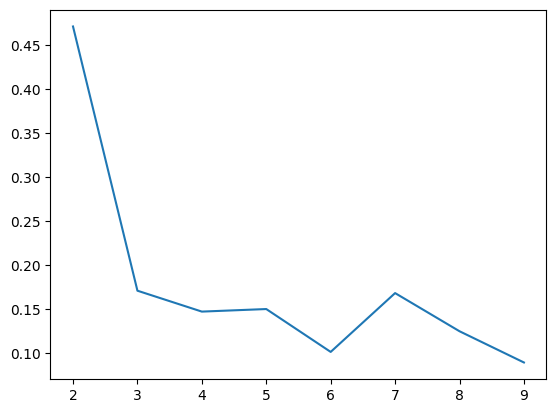

In [62]:
ss = []
s, e, d = 2, 10, 1
for i in tqdm(range(s, e, d)):
    x = ddt
    ss.append(silhouette_score(x, KMeans(i, n_init='auto').fit(x).labels_))
plt.plot(ss);
plt.xticks(range((e-s)//d), range(s, e, d));

100%|██████████| 24/24 [00:09<00:00,  2.51it/s]


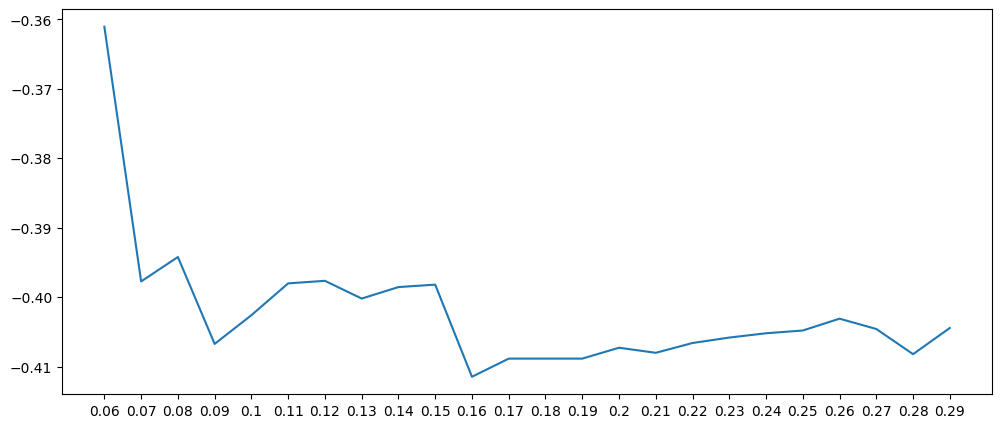

In [63]:
ss = []
s, e, d = 0.06, .3, 0.01

for i in tqdm(np.arange(s, e, d)):
    x = ddt
    ss.append(silhouette_score(x, DBSCAN(i).fit_predict(x)))
plt.figure(figsize=(12, 5))
plt.plot(ss);
plt.xticks(np.arange((e-s)/d), np.arange(s, e, d).round(2));

In [76]:
c = DBSCAN(0.28).fit_predict(ddt)

In [77]:
np.unique(table.drop_duplicates().loc[c!=-1]['Признак аварийности здания'], return_counts=True)

(array([0]), array([225]))

In [78]:
np.unique(table.drop_duplicates().loc[c==-1]['Признак аварийности здания'], return_counts=True)

(array([0, 1]), array([3951,    1]))

При использовании DBSCAN было выделенно что аварийные дома сильно выделимы по своим свойствам, как отдельный кластер

In [79]:
np.unique(table.drop_duplicates().loc[c==-1]['Район'], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([188, 485, 260, 400, 235, 108, 297, 361, 185, 151, 296, 187, 237,
         54, 368, 140]))

In [80]:
np.unique(table.drop_duplicates().loc[c==-1]['№ ОДС'], return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([65, 39, 45, 46, 62, 64, 14,  3, 33, 21, 30, 28, 27, 67, 44, 85, 12,
        22, 42, 85, 38, 32, 53, 40, 35, 55, 95, 35, 66, 33, 53, 46, 29, 50,
        72, 37, 83, 60, 32, 61, 28, 49, 18, 28, 49, 18, 29, 35, 27, 18, 49,
        70, 42, 40, 13, 76, 72, 17, 32, 64, 49, 33, 25, 47, 61, 58, 39, 25,
        32, 35, 27, 20, 17, 44, 33, 18, 23, 63, 55, 41, 27, 55, 24, 22, 17,
        13, 27, 25, 18, 19, 42, 19, 76, 23, 27, 1

In [69]:
np.unique(table.drop_duplicates().loc[c==-1]['Номер ТП'], return_counts=True)

(array([ -1,   0,   1,   2,   5,   6,   7,   9,  12,  15,  18,  19,  21,
         31,  32,  38,  39,  40,  41,  42,  46,  47,  48,  49,  50,  51,
         59,  61,  63,  65,  69,  71,  72,  74,  79,  80,  81,  87,  88,
         90,  97,  98, 102, 103, 106, 107, 111, 114, 118, 119, 124, 139,
        140, 149, 151, 152, 153, 154, 155, 157, 158, 159, 160, 162, 165,
        166, 168, 169, 171, 172, 176, 177, 189, 192, 193, 194, 202, 203,
        206, 207, 208, 218, 236, 241, 242, 243, 245, 247, 248, 249, 250,
        252, 256, 258, 259, 260, 262, 272, 273, 277, 279, 292, 293, 294,
        298, 300, 305, 307, 313, 315, 316, 317, 318, 320, 321, 327, 328,
        331, 332, 333, 338, 340, 344, 345, 348, 349, 351, 353, 354, 360,
        363, 368, 371, 374, 378, 380, 383, 384, 385, 387, 388, 391, 392,
        394, 395, 398, 399, 401, 403, 404, 406, 408, 411, 412, 419, 422,
        426, 430, 432, 434, 435, 436, 438, 439, 445, 447, 450, 452, 458,
        461, 462, 463, 468, 469, 470, 471, 475, 477